# Multiple Ticker Relative Model Performance: Rules Based vs RL
* Part I: Single Ticker
* Part II: Multiple Tickers

# SMA Bot vs SMA Bot With Reinforcement Learning
* compare rules based bots vs those with Q-Learning


| Model # | Name                                 | Features Used                                      | Type                    |
|---------|--------------------------------------|----------------------------------------------------|-------------------------|
| **Model 0** | SMA Rule-Based Strategy               | 10-day SMA                                           | Rule-Based              |
| **Model 1** | SMA + Volume (RL)                     | 10-day SMA, Volume                                   | Reinforcement Learning  |
| **Model 2** | SMA + Day of Week (RL)                | 10-day SMA, Day of Week                              | Reinforcement Learning  |
| **Model 3** | SMA + Volume + Day of Week (RL)       | 10-day SMA, Volume, Day of Week                      | Reinforcement Learning  |
| **Model 4** | SMA Only (RL)                         | 10-day SMA                                           | Reinforcement Learning  |
| **Model 5** | Mean Reversion Rule-Based Strategy    | 3-day return threshold                               | Rule-Based              |
| **Model 6** | Mean Reversion RL Strategy            | 1d & 3d returns, volatility, RSI                     | Reinforcement Learning  |


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

### Part I: Single Ticker

In [2]:
# Choose your ticker
ticker = "AAPL"  # Change to "MSFT", "TSLA", etc.

# Download data with MultiIndex columns
data = yf.download([ticker], period="2y", interval="1d")

# Add indicators BEFORE flattening
data[('SMA10', '')] = data[('Close', ticker)].rolling(window=10).mean()
data[('DayOfWeek', '')] = data.index.dayofweek

# Mean reversion features
data[('Return_1d', '')] = data[('Close', ticker)].pct_change()
data[('Return_3d', '')] = data[('Close', ticker)].pct_change(3)
data[('Volatility_5d', '')] = data[('Return_1d', '')].rolling(window=5).std()

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -1 * delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data[('RSI_14', '')] = compute_rsi(data[('Close', ticker)])

# Drop NaNs
data.dropna(inplace=True)

# Flatten MultiIndex columns
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

# Dynamically rename fields
data.rename(columns={
    f'Close_{ticker}': 'Close',
    f'Open_{ticker}': 'Open',
    f'High_{ticker}': 'High',
    f'Low_{ticker}': 'Low',
    f'Volume_{ticker}': 'Volume',
    'SMA10_': 'SMA10',
    'DayOfWeek_': 'DayOfWeek',
    'Return_1d_': 'Return_1d',
    'Return_3d_': 'Return_3d',
    'Volatility_5d_': 'Volatility_5d',
    'RSI_14_': 'RSI_14'
}, inplace=True)

# Reset index
data.reset_index(inplace=True)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

,Date,Close,High,Low,Open,Volume,SMA10,DayOfWeek,Return_1d,Return_3d,Volatility_5d,RSI_14
0,2023-04-17,163.580322,163.738728,162.392306,163.441721,41516200,162.278468,0,0.000121,0.032042,0.017050,65.207784
1,2023-04-18,164.807968,165.738586,163.996148,164.441667,49923000,162.308170,1,0.007505,0.005496,0.015765,68.797914
2,2023-04-19,165.956390,166.481098,163.887245,164.144659,47720200,162.506174,2,0.006968,0.014648,0.014478,65.953457
3,2023-04-20,164.986160,166.193981,163.907046,164.431754,52456400,162.792290,3,-0.005846,0.008594,0.005804,60.268071
4,2023-04-21,163.372437,164.788152,162.847729,163.402136,58337300,162.827930,4,-0.009781,-0.008710,0.007657,50.300307


In [4]:
# Reward function
def get_reward(action, price_today, price_tomorrow):
    if action == 1:
        return price_tomorrow - price_today
    elif action == -1:
        return price_today - price_tomorrow
    return 0

In [5]:
def compute_sharpe_ratio(rewards, risk_free_rate=0):
    if not rewards:
        return 0
    excess_returns = np.array(rewards) - risk_free_rate
    std_dev = np.std(excess_returns)
    return np.mean(excess_returns) / std_dev if std_dev != 0 else 0


def compute_max_drawdown(pnl_series):
    if not pnl_series:
        return 0
    cumulative = np.cumsum(pnl_series)
    peak = np.maximum.accumulate(cumulative)
    drawdown = cumulative - peak
    return np.min(drawdown)

In [6]:
def compute_trade_metrics(rewards):
    profits = [r for r in rewards if r > 0]
    losses = [-r for r in rewards if r < 0]  # flip to positive values
    num_wins = len(profits)
    num_losses = len(losses)

    profit_factor = sum(profits) / sum(losses) if sum(losses) != 0 else np.nan
    win_loss_ratio = num_wins / num_losses if num_losses != 0 else np.nan

    return {
        "Profit Factor": round(profit_factor, 2),
        "Win/Loss Ratio": round(win_loss_ratio, 2)
    }

### Models

In [7]:
# Model 0: Rule-based SMA Crossover
def run_sma_bot(df):
    df = df.copy()

    # Rename columns just in case
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
    df = df.reset_index(drop=True)

    # Use your renamed columns
    close_col = 'Close_AAPL' if 'Close_AAPL' in df.columns else 'Close'
    sma_col = 'SMA10_' if 'SMA10_' in df.columns else 'SMA10'

    position = 0
    cash = 0
    trades = 0
    rewards = []

    for i in range(1, len(df) - 1):
        try:
            price_prev = float(df.loc[i - 1, close_col])
            price_today = float(df.loc[i, close_col])
            price_tomorrow = float(df.loc[i + 1, close_col])
            sma_prev = float(df.loc[i - 1, sma_col])
            sma_today = float(df.loc[i, sma_col])
        except:
            continue

        if pd.isna(price_today) or pd.isna(sma_today) or pd.isna(sma_prev) or pd.isna(price_prev):
            continue

        # Detect upward crossover: price crosses above SMA
        if price_prev < sma_prev and price_today > sma_today and position == 0:
            position = price_today
            trades += 1

        # Detect downward crossover: price crosses below SMA
        elif price_prev > sma_prev and price_today < sma_today and position != 0:
            pnl = price_today - position
            cash += pnl
            rewards.append(pnl)
            position = 0
            trades += 1

    # Close open position at final price
    if position != 0:
        final_pnl = float(df.loc[len(df) - 1, close_col]) - position
        cash += final_pnl
        rewards.append(final_pnl)

    cumulative_pnl = np.cumsum(rewards)
    avg_price = df['Close'].mean()
    total_return_pct = (cash / avg_price) * 100
    avg_daily_pct = (np.mean(rewards) / avg_price) * 100 if rewards else 0

    metrics = compute_trade_metrics(rewards)
    
    return {
        "Model": "Model0 (Rule SMA)",
        "Total Return ($)": round(cash, 2),
        "Total Return (%)": round(total_return_pct, 2),
        "Avg Daily Reward": round(np.mean(rewards), 4) if rewards else 0,
        "Avg Daily Reward (%)": round(avg_daily_pct, 4),
        "# Trades": trades,
        "Cumulative Reward": round(np.sum(rewards), 2),
        "Sharpe Ratio": round(compute_sharpe_ratio(rewards), 4) if rewards else 0,
        "Max Drawdown": round(compute_max_drawdown(rewards), 2) if rewards else 0,
        "Profit Factor": metrics["Profit Factor"],
        "Win/Loss Ratio": metrics["Win/Loss Ratio"],
        "Avg Trade Duration": round(len(df) / trades, 2) if trades > 0 else np.nan
    }



In [8]:
# RL Models
def preprocess_features(df, model):
    features = ['SMA10']
    if model == 1:
        features.append('Volume')
    elif model == 2:
        features.append('DayOfWeek')
    elif model == 3:
        features += ['Volume', 'DayOfWeek']
    elif model == 4:
        features = ['SMA10']  # Only SMA for RL

    X = df[features]
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    X_binned = est.fit_transform(X)
    return X_binned.astype(int)

def run_rl_model(df, model_num):
    states = preprocess_features(df, model_num)
    n_states = tuple([5] * states.shape[1])
    actions = [-1, 0, 1]  # Sell, Hold, Buy

    Q_table = np.zeros(n_states + (len(actions),))

    alpha = 0.1
    gamma = 0.9
    epsilon = 0.1
    cash = 0
    position = 0
    trades = 0
    rewards = []

    for t in range(len(states) - 1):
        state = tuple(states[t])
        next_state = tuple(states[t + 1])
        price_today = df.iloc[t]['Close']
        price_tomorrow = df.iloc[t + 1]['Close']

        if np.random.rand() < epsilon:
            action_idx = np.random.choice(len(actions))
        else:
            action_idx = np.argmax(Q_table[state])
        action = actions[action_idx]

        reward = get_reward(action, price_today, price_tomorrow)
        rewards.append(reward)

        Q_table[state + (action_idx,)] += alpha * (
            reward + gamma * np.max(Q_table[next_state]) - Q_table[state + (action_idx,)]
        )

        if action == 1 and position == 0:
            position = price_today
            trades += 1
        elif action == -1 and position != 0:
            cash += price_today - position
            position = 0
            trades += 1

    if position != 0:
        cash += df.iloc[-1]['Close'] - position

    cumulative_pnl = np.cumsum(rewards)
    avg_price = df['Close'].mean()
    total_return_pct = (cash / avg_price) * 100
    avg_daily_pct = (np.mean(rewards) / avg_price) * 100 if rewards else 0

    metrics = compute_trade_metrics(rewards)
    
    return {
        "Model": f"Model{model_num} (RL)",
        "Total Return ($)": round(cash, 2),
        "Total Return (%)": round(total_return_pct, 2),
        "Avg Daily Reward": round(np.mean(rewards), 4) if rewards else 0,
        "Avg Daily Reward (%)": round(avg_daily_pct, 4),
        "# Trades": trades,
        "Cumulative Reward": round(np.sum(rewards), 2),
        "Sharpe Ratio": round(compute_sharpe_ratio(rewards), 4) if rewards else 0,
        "Max Drawdown": round(compute_max_drawdown(rewards), 2) if rewards else 0,
        "Profit Factor": metrics["Profit Factor"],
        "Win/Loss Ratio": metrics["Win/Loss Ratio"],
        "Avg Trade Duration": round(len(df) / trades, 2) if trades > 0 else np.nan
    }

In [9]:
def run_mean_reversion_rule_bot(df):
    position = 0
    cash = 0
    trades = 0
    rewards = []

    for i in range(1, len(df) - 1):
        try:
            r3 = df.loc[i, 'Return_3d']
            price_today = df.loc[i, 'Close']
            price_tomorrow = df.loc[i + 1, 'Close']
        except:
            continue

        if pd.isna(r3) or pd.isna(price_today):
            continue

        if r3 < -0.03 and position == 0:  # Buy the dip
            position = price_today
            trades += 1
        elif r3 > 0 and position != 0:  # Sell on recovery
            pnl = price_today - position
            cash += pnl
            rewards.append(pnl)
            position = 0
            trades += 1

    if position != 0:
        final_pnl = df.loc[len(df) - 1, 'Close'] - position
        cash += final_pnl
        rewards.append(final_pnl)

    cumulative_pnl = np.cumsum(rewards)
    avg_price = df['Close'].mean()
    total_return_pct = (cash / avg_price) * 100
    avg_daily_pct = (np.mean(rewards) / avg_price) * 100 if rewards else 0

    metrics = compute_trade_metrics(rewards)
    
    return {
        "Model": "Model5 (Rule Mean Reversion)",
        "Total Return ($)": round(cash, 2),
        "Total Return (%)": round(total_return_pct, 2),
        "Avg Daily Reward": round(np.mean(rewards), 4) if rewards else 0,
        "Avg Daily Reward (%)": round(avg_daily_pct, 4),
        "# Trades": trades,
        "Cumulative Reward": round(np.sum(rewards), 2),
        "Sharpe Ratio": round(compute_sharpe_ratio(rewards), 4) if rewards else 0,
        "Max Drawdown": round(compute_max_drawdown(rewards), 2) if rewards else 0,
        "Profit Factor": metrics["Profit Factor"],
        "Win/Loss Ratio": metrics["Win/Loss Ratio"],
        "Avg Trade Duration": round(len(df) / trades, 2) if trades > 0 else np.nan
    }


In [10]:
def run_rl_mean_reversion_bot(df):
    features = ['Return_1d', 'Return_3d', 'Volatility_5d', 'RSI_14']
    X = df[features].copy()
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    states = est.fit_transform(X).astype(int)
    actions = [-1, 0, 1]  # Sell, Hold, Buy

    Q_table = np.zeros((5, 5, 5, 5, len(actions)))

    alpha = 0.1
    gamma = 0.9
    epsilon = 0.1
    cash = 0
    position = 0
    trades = 0
    rewards = []

    for t in range(len(states) - 1):
        state = tuple(states[t])
        next_state = tuple(states[t + 1])
        price_today = df.loc[t, 'Close']
        price_tomorrow = df.loc[t + 1, 'Close']

        # Choose action
        if np.random.rand() < epsilon:
            action_idx = np.random.choice(len(actions))
        else:
            action_idx = np.argmax(Q_table[state])
        action = actions[action_idx]

        reward = 0
        if action == 1 and position == 0:
            position = price_today
            trades += 1
        elif action == -1 and position != 0:
            pnl = price_today - position
            cash += pnl
            reward = pnl
            position = 0
            trades += 1

        rewards.append(reward)

        Q_table[state + (action_idx,)] += alpha * (
            reward + gamma * np.max(Q_table[next_state]) - Q_table[state + (action_idx,)]
        )

    if position != 0:
        final_pnl = df.loc[len(df) - 1, 'Close'] - position
        cash += final_pnl
        rewards.append(final_pnl)

    cumulative_pnl = np.cumsum(rewards)
    avg_price = df['Close'].mean()
    total_return_pct = (cash / avg_price) * 100
    avg_daily_pct = (np.mean(rewards) / avg_price) * 100 if rewards else 0

    metrics = compute_trade_metrics(rewards)
    
    return {
        "Model": "Model6 (RL Mean Reversion)",
        "Total Return ($)": round(cash, 2),
        "Total Return (%)": round(total_return_pct, 2),
        "Avg Daily Reward": round(np.mean(rewards), 4) if rewards else 0,
        "Avg Daily Reward (%)": round(avg_daily_pct, 4),
        "# Trades": trades,
        "Cumulative Reward": round(np.sum(rewards), 2),
        "Sharpe Ratio": round(compute_sharpe_ratio(rewards), 4) if rewards else 0,
        "Max Drawdown": round(compute_max_drawdown(rewards), 2) if rewards else 0,
        "Profit Factor": metrics["Profit Factor"],
        "Win/Loss Ratio": metrics["Win/Loss Ratio"],
        "Avg Trade Duration": round(len(df) / trades, 2) if trades > 0 else np.nan
    }


### Results

In [11]:
# Run all models
results = []

# Original models
results.append(run_sma_bot(data))           # Model0
for model_num in range(1, 5):               # Model1–4
    results.append(run_rl_model(data, model_num))

# New models
results.append(run_mean_reversion_rule_bot(data))   # Model5
results.append(run_rl_mean_reversion_bot(data))     # Model6

# Summary
summary = pd.DataFrame(results)
print(summary.to_string(index=False))


                       Model  Total Return ($)  Total Return (%)  Avg Daily Reward  Avg Daily Reward (%)  # Trades  Cumulative Reward  Sharpe Ratio  Max Drawdown  Profit Factor  Win/Loss Ratio  Avg Trade Duration
           Model0 (Rule SMA)             63.74             31.90            1.6775                0.8394        75              63.74        0.2373        -15.11           2.05            0.65                6.49
                 Model1 (RL)             53.27             26.66            0.0504                0.0252        33              24.51        0.0299        -51.25           1.19            1.25               14.76
                 Model2 (RL)             46.51             23.27           -0.1190               -0.0595        37             -57.83       -0.0897        -72.98           0.62            0.62               13.16
                 Model3 (RL)             16.38              8.20           -0.1008               -0.0504        37             -48.97       -0.0613 

In [12]:
summary

,Model,Total Return ($),Total Return (%),Avg Daily Reward,Avg Daily Reward (%),# Trades,Cumulative Reward,Sharpe Ratio,Max Drawdown,Profit Factor,Win/Loss Ratio,Avg Trade Duration
0,Model0 (Rule SMA),63.74,31.90,1.6775,0.8394,75,63.74,0.2373,-15.11,2.05,0.65,6.49
1,Model1 (RL),53.27,26.66,0.0504,0.0252,33,24.51,0.0299,-51.25,1.19,1.25,14.76
2,Model2 (RL),46.51,23.27,-0.1190,-0.0595,37,-57.83,-0.0897,-72.98,0.62,0.62,13.16
3,Model3 (RL),16.38,8.20,-0.1008,-0.0504,37,-48.97,-0.0613,-70.97,0.72,0.75,13.16
4,Model4 (RL),15.06,7.53,-0.0402,-0.0201,18,-19.52,-0.0279,-54.21,0.80,0.94,27.06
5,Model5 (Rule Mean Reversion),-0.49,-0.24,-0.0222,-0.0111,44,-0.49,-0.0045,-20.21,0.99,2.14,11.07
6,Model6 (RL Mean Reversion),-3.08,-1.54,-0.0063,-0.0032,34,-3.08,-0.0086,-11.59,0.88,1.12,14.32


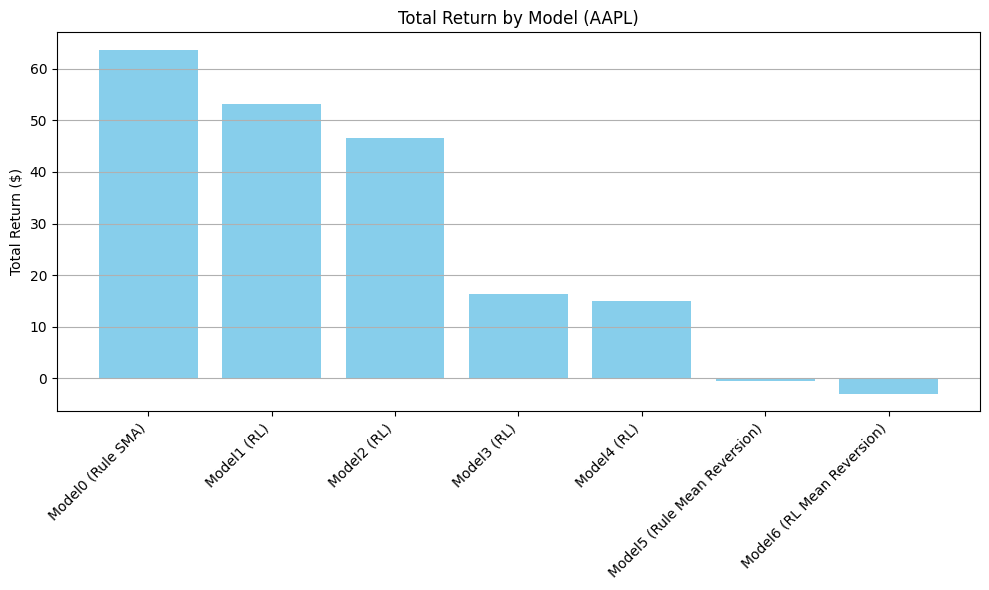

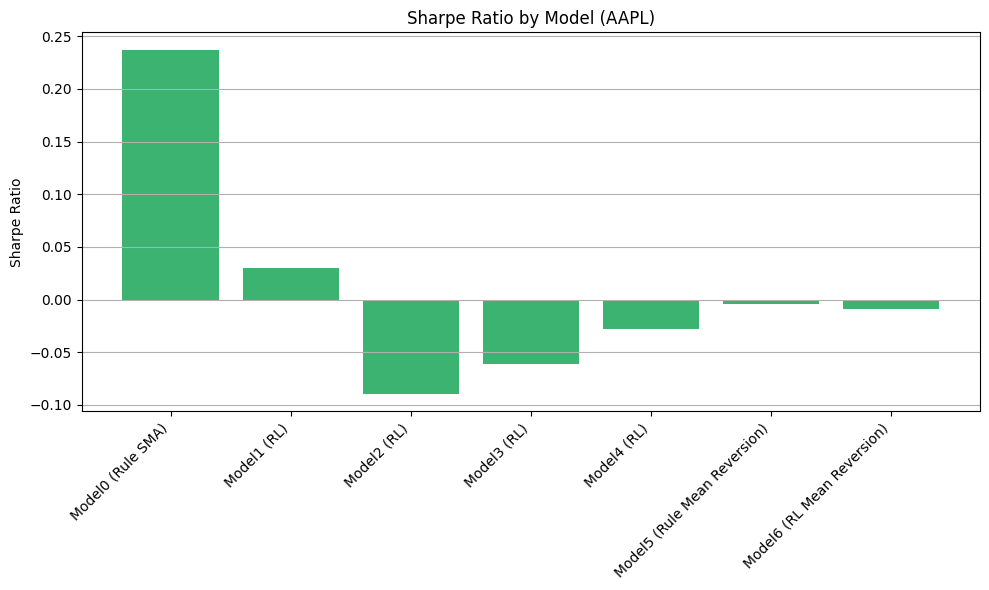

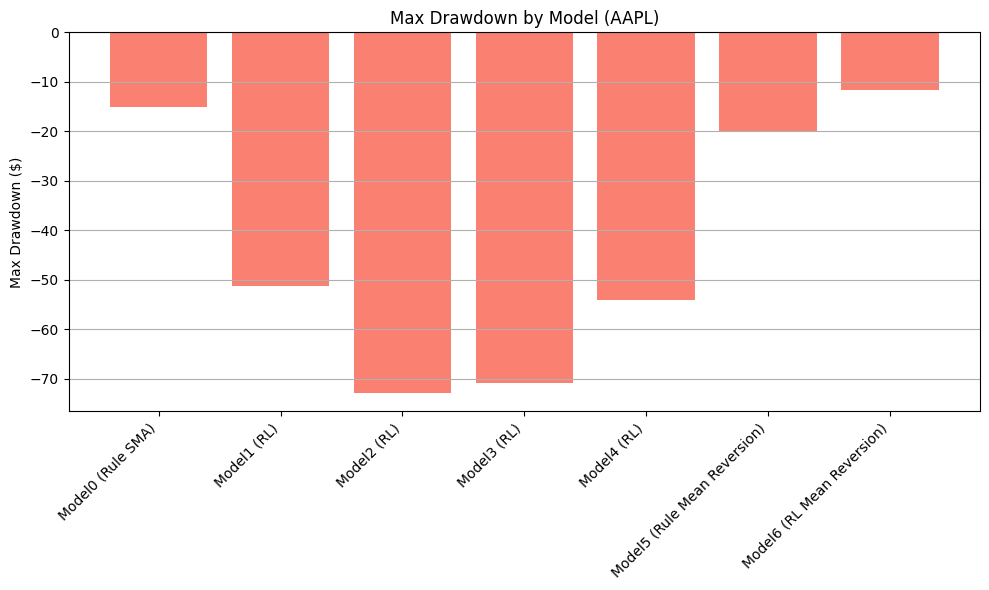

In [13]:
# visual

# Plot 1: Total Return by Model
plt.figure(figsize=(10, 6))
plt.bar(summary['Model'], summary['Total Return ($)'], color='skyblue')
plt.title(f'Total Return by Model ({ticker})')
plt.ylabel('Total Return ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot 2: Sharpe Ratio by Model
plt.figure(figsize=(10, 6))
plt.bar(summary['Model'], summary['Sharpe Ratio'], color='mediumseagreen')
plt.title(f'Sharpe Ratio by Model ({ticker})')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot 3: Max Drawdown by Model
plt.figure(figsize=(10, 6))
plt.bar(summary['Model'], summary['Max Drawdown'], color='salmon')
plt.title(f'Max Drawdown by Model ({ticker})')
plt.ylabel('Max Drawdown ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Part II: Multiple Ticker Analysis

In [14]:
def run_all_models_for_ticker(ticker, sector=None):
    # sector is used in part III
    try:
        print(f"Downloading data for {ticker}...")
        data = yf.download([ticker], period="2y", interval="1d")

        if data.empty:
            print(f" No data returned for {ticker}")
            return []

        # Add indicators BEFORE flattening
        data[('SMA10', '')] = data[('Close', ticker)].rolling(window=10).mean()
        data[('DayOfWeek', '')] = data.index.dayofweek

        # Mean reversion features
        close = data[('Close', ticker)]
        data[('Return_1d', '')] = close.pct_change()
        data[('Return_3d', '')] = close.pct_change(3)
        data[('Volatility_5d', '')] = data[('Return_1d', '')].rolling(window=5).std()
        data[('RSI_14', '')] = compute_rsi(close)

        # Drop NaNs
        data.dropna(inplace=True)

        # Flatten MultiIndex columns
        data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

        # Rename for general use
        rename_cols = {
            f'Close_{ticker}': 'Close',
            f'Open_{ticker}': 'Open',
            f'High_{ticker}': 'High',
            f'Low_{ticker}': 'Low',
            f'Volume_{ticker}': 'Volume',
            'SMA10_': 'SMA10',
            'DayOfWeek_': 'DayOfWeek',
            'Return_1d_': 'Return_1d',
            'Return_3d_': 'Return_3d',
            'Volatility_5d_': 'Volatility_5d',
            'RSI_14_': 'RSI_14'
        }
        data.rename(columns=rename_cols, inplace=True)
        data.reset_index(inplace=True)

        # --- Run models ---
        print(f"Running models for {ticker}...")
        model_results = [
            run_sma_bot(data),
            run_rl_model(data, 1),
            run_rl_model(data, 2),
            run_rl_model(data, 3),
            run_rl_model(data, 4),
            run_mean_reversion_rule_bot(data),
            run_rl_mean_reversion_bot(data)
        ]

        for result in model_results:
            result["Ticker"] = ticker
            result['Sector']= sector

        print(f" Finished {ticker}")
        return model_results

    except Exception as e:
        print(f" Error for {ticker}: {e}")
        return []

In [15]:
tickers = ["AAPL", "MSFT", "TSLA", "NVDA", "GOOGL", "AMZN", "META"]
all_results = []

for ticker in tickers:
    print(f"\n--- Processing {ticker} ---")
    all_results.extend(run_all_models_for_ticker(ticker))

[*********************100%***********************]  1 of 1 completed


--- Processing AAPL ---
Running models for AAPL...



[*********************100%***********************]  1 of 1 completed

 Finished AAPL

--- Processing MSFT ---
Running models for MSFT...



[*********************100%***********************]  1 of 1 completed

 Finished MSFT

--- Processing TSLA ---
Running models for TSLA...



[*********************100%***********************]  1 of 1 completed

 Finished TSLA

--- Processing NVDA ---
Running models for NVDA...



[*********************100%***********************]  1 of 1 completed

 Finished NVDA

--- Processing GOOGL ---
Running models for GOOGL...



[*********************100%***********************]  1 of 1 completed

 Finished GOOGL

--- Processing AMZN ---
Running models for AMZN...



[*********************100%***********************]  1 of 1 completed

 Finished AMZN

--- Processing META ---
Running models for META...


 Finished META


In [16]:
all_results

[{'Model': 'Model0 (Rule SMA)',
  'Total Return ($)': 63.74,
  'Total Return (%)': 31.9,
  'Avg Daily Reward': 1.6775,
  'Avg Daily Reward (%)': 0.8394,
  '# Trades': 75,
  'Cumulative Reward': 63.74,
  'Sharpe Ratio': 0.2373,
  'Max Drawdown': -15.11,
  'Profit Factor': 2.05,
  'Win/Loss Ratio': 0.65,
  'Avg Trade Duration': 6.49,
  'Ticker': 'AAPL',
  'Sector': None},
 {'Model': 'Model1 (RL)',
  'Total Return ($)': 29.8,
  'Total Return (%)': 14.91,
  'Avg Daily Reward': 0.0309,
  'Avg Daily Reward (%)': 0.0155,
  '# Trades': 33,
  'Cumulative Reward': 15.01,
  'Sharpe Ratio': 0.0185,
  'Max Drawdown': -44.32,
  'Profit Factor': 1.09,
  'Win/Loss Ratio': 1.23,
  'Avg Trade Duration': 14.76,
  'Ticker': 'AAPL',
  'Sector': None},
 {'Model': 'Model2 (RL)',
  'Total Return ($)': 83.75,
  'Total Return (%)': 41.91,
  'Avg Daily Reward': -0.0416,
  'Avg Daily Reward (%)': -0.0208,
  '# Trades': 41,
  'Cumulative Reward': -20.23,
  'Sharpe Ratio': -0.0248,
  'Max Drawdown': -52.07,
  'Prof

In [17]:
df_all = pd.DataFrame(all_results)

# Rank models within each ticker (by Total Return %)
df_all['Rank'] = df_all.groupby('Ticker')["Total Return (%)"].rank(ascending=False)

# Optional: Round for nicer display
df_all = df_all.round(2)


#### Summary: How often each model ranks in top 1 or 2

In [18]:
top2_counts = df_all[df_all["Rank"] <= 2]["Model"].value_counts().sort_values(ascending=False)
top2_percent = (top2_counts / len(tickers) * 100).round(1)

summary_table = pd.DataFrame({
    "Top 2 Count": top2_counts,
    "Top 2 %": top2_percent
})
display(summary_table)


,Top 2 Count,Top 2 %
Model,,
Model0 (Rule SMA),5,71.4
Model2 (RL),4,57.1
Model5 (Rule Mean Reversion),2,28.6
Model4 (RL),2,28.6
Model3 (RL),1,14.3


C:\Users\JR\AppData\Local\Temp\ipykernel_11116\667700075.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Total Return (%)', data=df_all, palette=palette, showmeans=True,


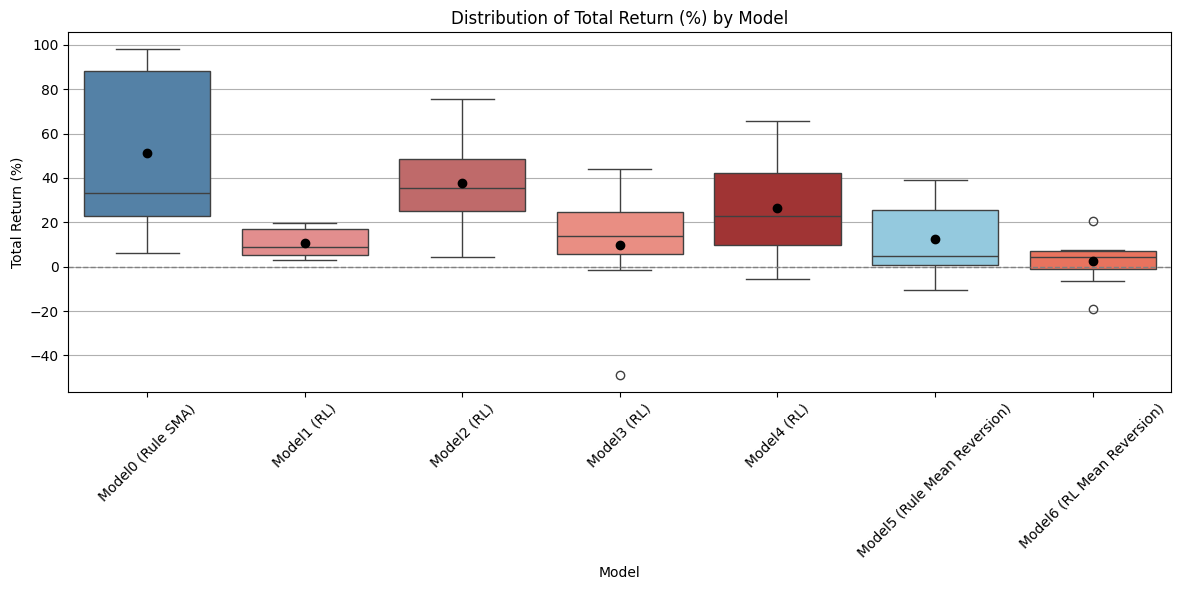

In [19]:
# visualization

# Boxplot of Total Return % by Model
plt.figure(figsize=(12, 6))
palette = {
    'Model0 (Rule SMA)': 'steelblue',
    'Model5 (Rule Mean Reversion)': 'skyblue',
    'Model1 (RL)': 'lightcoral',
    'Model2 (RL)': 'indianred',
    'Model3 (RL)': 'salmon',
    'Model4 (RL)': 'firebrick',
    'Model6 (RL Mean Reversion)': 'tomato'
}
sns.boxplot(x='Model', y='Total Return (%)', data=df_all, palette=palette, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"})
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.xticks(rotation=45)
plt.title("Distribution of Total Return (%) by Model")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

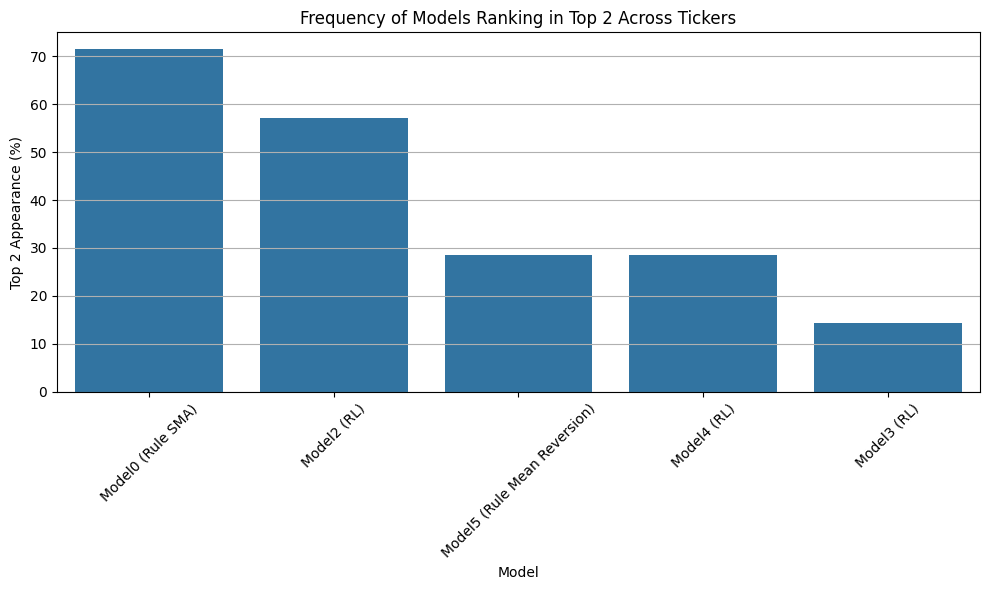

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_table.index, y="Top 2 %", data=summary_table)
plt.title("Frequency of Models Ranking in Top 2 Across Tickers")
plt.ylabel("Top 2 Appearance (%)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Part III: All Tickers In S&P 500 and sector analysis

In [21]:
sp_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp_df['Symbol'] = sp_df['Symbol'].str.replace(r'\.', '-', regex=True)
sp_df = sp_df[['Symbol', 'Security', 'GICS Sector']]

In [22]:
from tqdm import tqdm  # optional, shows progress bar

all_results = []

for _, row in tqdm(sp_df.iterrows(), total=len(sp_df)):
    symbol = row['Symbol']
    sector = row['GICS Sector']
    results = run_all_models_for_ticker(symbol, sector=sector)
    all_results.extend(results)


[*********************100%***********************]  1 of 1 completed


Running models for MMM...


[*********************100%***********************]  1 of 1 completed

 Finished MMM
Running models for AOS...



[*********************100%***********************]  1 of 1 completed

 Finished AOS
Running models for ABT...



[*********************100%***********************]  1 of 1 completed

 Finished ABT
Running models for ABBV...



[*********************100%***********************]  1 of 1 completed

 Finished ABBV
Running models for ACN...



[*********************100%***********************]  1 of 1 completed

 Finished ACN
Running models for ADBE...



[*********************100%***********************]  1 of 1 completed

 Finished ADBE
Running models for AMD...



[*********************100%***********************]  1 of 1 completed

 Finished AMD
Running models for AES...



[*********************100%***********************]  1 of 1 completed

 Finished AES
Running models for AFL...



[*********************100%***********************]  1 of 1 completed

 Finished AFL
Running models for A...



[*********************100%***********************]  1 of 1 completed

 Finished A
Running models for APD...



[*********************100%***********************]  1 of 1 completed

 Finished APD
Running models for ABNB...



[*********************100%***********************]  1 of 1 completed

 Finished ABNB
Running models for AKAM...



[*********************100%***********************]  1 of 1 completed

 Finished AKAM
Running models for ALB...



[*********************100%***********************]  1 of 1 completed

 Finished ALB
Running models for ARE...



[*********************100%***********************]  1 of 1 completed

 Finished ARE
Running models for ALGN...



[*********************100%***********************]  1 of 1 completed

 Finished ALGN
Running models for ALLE...



[*********************100%***********************]  1 of 1 completed

 Finished ALLE
Running models for LNT...



[*********************100%***********************]  1 of 1 completed

 Finished LNT
Running models for ALL...



[*********************100%***********************]  1 of 1 completed

 Finished ALL
Running models for GOOGL...



[*********************100%***********************]  1 of 1 completed

 Finished GOOGL
Running models for GOOG...



  4%|▍         | 21/503 [00:14<05:40,  1.42it/s]

 Finished GOOG


[*********************100%***********************]  1 of 1 completed


Running models for MO...


[*********************100%***********************]  1 of 1 completed

 Finished MO
Running models for AMZN...



[*********************100%***********************]  1 of 1 completed

 Finished AMZN
Running models for AMCR...



[*********************100%***********************]  1 of 1 completed

 Finished AMCR
Running models for AEE...



  5%|▍         | 25/503 [00:16<05:38,  1.41it/s]

 Finished AEE


[*********************100%***********************]  1 of 1 completed


Running models for AEP...


[*********************100%***********************]  1 of 1 completed

 Finished AEP
Running models for AXP...



[*********************100%***********************]  1 of 1 completed

 Finished AXP
Running models for AIG...



[*********************100%***********************]  1 of 1 completed

 Finished AIG
Running models for AMT...



[*********************100%***********************]  1 of 1 completed

 Finished AMT
Running models for AWK...



[*********************100%***********************]  1 of 1 completed

 Finished AWK
Running models for AMP...



[*********************100%***********************]  1 of 1 completed

 Finished AMP
Running models for AME...



[*********************100%***********************]  1 of 1 completed

 Finished AME
Running models for AMGN...



[*********************100%***********************]  1 of 1 completed

 Finished AMGN
Running models for APH...



[*********************100%***********************]  1 of 1 completed

 Finished APH
Running models for ADI...



[*********************100%***********************]  1 of 1 completed

 Finished ADI
Running models for ANSS...



[*********************100%***********************]  1 of 1 completed

 Finished ANSS
Running models for AON...



[*********************100%***********************]  1 of 1 completed

 Finished AON
Running models for APA...



[*********************100%***********************]  1 of 1 completed

 Finished APA
Running models for APO...



[*********************100%***********************]  1 of 1 completed

 Finished APO
Running models for AAPL...



[*********************100%***********************]  1 of 1 completed

 Finished AAPL
Running models for AMAT...



[*********************100%***********************]  1 of 1 completed

 Finished AMAT
Running models for APTV...



[*********************100%***********************]  1 of 1 completed

 Finished APTV
Running models for ACGL...



[*********************100%***********************]  1 of 1 completed

 Finished ACGL


Running models for ADM...


[*********************100%***********************]  1 of 1 completed

 Finished ADM


Running models for ANET...


[*********************100%***********************]  1 of 1 completed

 Finished ANET
Running models for AJG...



[*********************100%***********************]  1 of 1 completed

 Finished AJG
Running models for AIZ...



[*********************100%***********************]  1 of 1 completed

 Finished AIZ
Running models for T...



[*********************100%***********************]  1 of 1 completed

 Finished T


Running models for ATO...


[*********************100%***********************]  1 of 1 completed

 Finished ATO
Running models for ADSK...



[*********************100%***********************]  1 of 1 completed

 Finished ADSK


Running models for ADP...


[*********************100%***********************]  1 of 1 completed

 Finished ADP
Running models for AZO...



[*********************100%***********************]  1 of 1 completed

 Finished AZO


Running models for AVB...


[*********************100%***********************]  1 of 1 completed

 Finished AVB
Running models for AVY...



[*********************100%***********************]  1 of 1 completed

 Finished AVY
Running models for AXON...



[*********************100%***********************]  1 of 1 completed

 Finished AXON
Running models for BKR...



[*********************100%***********************]  1 of 1 completed

 Finished BKR
Running models for BALL...



[*********************100%***********************]  1 of 1 completed

 Finished BALL
Running models for BAC...



[*********************100%***********************]  1 of 1 completed

 Finished BAC
Running models for BAX...



[*********************100%***********************]  1 of 1 completed

 Finished BAX
Running models for BDX...



[*********************100%***********************]  1 of 1 completed

 Finished BDX
Running models for BRK-B...



[*********************100%***********************]  1 of 1 completed

 Finished BRK-B
Running models for BBY...



[*********************100%***********************]  1 of 1 completed

 Finished BBY
Running models for TECH...



[*********************100%***********************]  1 of 1 completed

 Finished TECH
Running models for BIIB...



[*********************100%***********************]  1 of 1 completed

 Finished BIIB
Running models for BLK...



 13%|█▎        | 65/503 [00:55<05:19,  1.37it/s]

 Finished BLK


[*********************100%***********************]  1 of 1 completed


Running models for BX...


[*********************100%***********************]  1 of 1 completed

 Finished BX
Running models for BK...



[*********************100%***********************]  1 of 1 completed

 Finished BK
Running models for BA...



[*********************100%***********************]  1 of 1 completed

 Finished BA
Running models for BKNG...



[*********************100%***********************]  1 of 1 completed

 Finished BKNG
Running models for BSX...



[*********************100%***********************]  1 of 1 completed

 Finished BSX


Running models for BMY...


[*********************100%***********************]  1 of 1 completed

 Finished BMY
Running models for AVGO...



[*********************100%***********************]  1 of 1 completed

 Finished AVGO
Running models for BR...



[*********************100%***********************]  1 of 1 completed

 Finished BR
Running models for BRO...



[*********************100%***********************]  1 of 1 completed

 Finished BRO
Running models for BF-B...



[*********************100%***********************]  1 of 1 completed

 Finished BF-B
Running models for BLDR...



[*********************100%***********************]  1 of 1 completed

 Finished BLDR
Running models for BG...



[*********************100%***********************]  1 of 1 completed

 Finished BG
Running models for BXP...



[*********************100%***********************]  1 of 1 completed

 Finished BXP
Running models for CHRW...



[*********************100%***********************]  1 of 1 completed

 Finished CHRW
Running models for CDNS...



[*********************100%***********************]  1 of 1 completed

 Finished CDNS
Running models for CZR...



[*********************100%***********************]  1 of 1 completed

 Finished CZR
Running models for CPT...



[*********************100%***********************]  1 of 1 completed

 Finished CPT
Running models for CPB...



[*********************100%***********************]  1 of 1 completed

 Finished CPB
Running models for COF...



[*********************100%***********************]  1 of 1 completed

 Finished COF
Running models for CAH...



[*********************100%***********************]  1 of 1 completed

 Finished CAH
Running models for KMX...



[*********************100%***********************]  1 of 1 completed

 Finished KMX
Running models for CCL...



[*********************100%***********************]  1 of 1 completed

 Finished CCL
Running models for CARR...



 17%|█▋        | 88/503 [01:12<05:00,  1.38it/s]

 Finished CARR


[*********************100%***********************]  1 of 1 completed


Running models for CAT...


[*********************100%***********************]  1 of 1 completed

 Finished CAT
Running models for CBOE...



[*********************100%***********************]  1 of 1 completed

 Finished CBOE
Running models for CBRE...



[*********************100%***********************]  1 of 1 completed

 Finished CBRE
Running models for CDW...



[*********************100%***********************]  1 of 1 completed

 Finished CDW
Running models for COR...



[*********************100%***********************]  1 of 1 completed

 Finished COR
Running models for CNC...



[*********************100%***********************]  1 of 1 completed

 Finished CNC
Running models for CNP...



[*********************100%***********************]  1 of 1 completed

 Finished CNP
Running models for CF...



[*********************100%***********************]  1 of 1 completed

 Finished CF
Running models for CRL...



[*********************100%***********************]  1 of 1 completed

 Finished CRL
Running models for SCHW...



[*********************100%***********************]  1 of 1 completed

 Finished SCHW
Running models for CHTR...



[*********************100%***********************]  1 of 1 completed

 Finished CHTR
Running models for CVX...



[*********************100%***********************]  1 of 1 completed

 Finished CVX
Running models for CMG...



[*********************100%***********************]  1 of 1 completed

 Finished CMG
Running models for CB...



[*********************100%***********************]  1 of 1 completed

 Finished CB
Running models for CHD...



[*********************100%***********************]  1 of 1 completed

 Finished CHD
Running models for CI...



[*********************100%***********************]  1 of 1 completed

 Finished CI
Running models for CINF...



[*********************100%***********************]  1 of 1 completed

 Finished CINF
Running models for CTAS...



[*********************100%***********************]  1 of 1 completed

 Finished CTAS
Running models for CSCO...



[*********************100%***********************]  1 of 1 completed

 Finished CSCO
Running models for C...



[*********************100%***********************]  1 of 1 completed

 Finished C
Running models for CFG...



[*********************100%***********************]  1 of 1 completed

 Finished CFG


Running models for CLX...


[*********************100%***********************]  1 of 1 completed

 Finished CLX
Running models for CME...



[*********************100%***********************]  1 of 1 completed

 Finished CME
Running models for CMS...



[*********************100%***********************]  1 of 1 completed

 Finished CMS


Running models for KO...


[*********************100%***********************]  1 of 1 completed

 Finished KO
Running models for CTSH...



[*********************100%***********************]  1 of 1 completed

 Finished CTSH
Running models for CL...



[*********************100%***********************]  1 of 1 completed

 Finished CL
Running models for CMCSA...



[*********************100%***********************]  1 of 1 completed

 Finished CMCSA
Running models for CAG...



[*********************100%***********************]  1 of 1 completed

 Finished CAG
Running models for COP...



 23%|██▎       | 118/503 [01:34<04:38,  1.38it/s]

 Finished COP


[*********************100%***********************]  1 of 1 completed


Running models for ED...


[*********************100%***********************]  1 of 1 completed

 Finished ED
Running models for STZ...



[*********************100%***********************]  1 of 1 completed

 Finished STZ
Running models for CEG...



[*********************100%***********************]  1 of 1 completed

 Finished CEG
Running models for COO...



[*********************100%***********************]  1 of 1 completed

 Finished COO
Running models for CPRT...



[*********************100%***********************]  1 of 1 completed

 Finished CPRT
Running models for GLW...



[*********************100%***********************]  1 of 1 completed

 Finished GLW
Running models for CPAY...



[*********************100%***********************]  1 of 1 completed

 Finished CPAY
Running models for CTVA...



 25%|██▌       | 126/503 [01:41<05:17,  1.19it/s]

 Finished CTVA


[*********************100%***********************]  1 of 1 completed


Running models for CSGP...


[*********************100%***********************]  1 of 1 completed

 Finished CSGP
Running models for COST...



[*********************100%***********************]  1 of 1 completed

 Finished COST
Running models for CTRA...



[*********************100%***********************]  1 of 1 completed

 Finished CTRA
Running models for CRWD...



[*********************100%***********************]  1 of 1 completed

 Finished CRWD
Running models for CCI...



[*********************100%***********************]  1 of 1 completed

 Finished CCI
Running models for CSX...



[*********************100%***********************]  1 of 1 completed

 Finished CSX
Running models for CMI...



[*********************100%***********************]  1 of 1 completed

 Finished CMI
Running models for CVS...



[*********************100%***********************]  1 of 1 completed

 Finished CVS
Running models for DHR...



[*********************100%***********************]  1 of 1 completed

 Finished DHR
Running models for DRI...



[*********************100%***********************]  1 of 1 completed

 Finished DRI
Running models for DVA...



[*********************100%***********************]  1 of 1 completed

 Finished DVA
Running models for DAY...



[*********************100%***********************]  1 of 1 completed

 Finished DAY
Running models for DECK...



[*********************100%***********************]  1 of 1 completed

 Finished DECK
Running models for DE...



[*********************100%***********************]  1 of 1 completed

 Finished DE
Running models for DELL...



 28%|██▊       | 141/503 [01:52<04:09,  1.45it/s]

 Finished DELL


[*********************100%***********************]  1 of 1 completed


Running models for DAL...


[*********************100%***********************]  1 of 1 completed

 Finished DAL
Running models for DVN...



[*********************100%***********************]  1 of 1 completed

 Finished DVN
Running models for DXCM...



[*********************100%***********************]  1 of 1 completed

 Finished DXCM
Running models for FANG...



[*********************100%***********************]  1 of 1 completed

 Finished FANG
Running models for DLR...



[*********************100%***********************]  1 of 1 completed

 Finished DLR
Running models for DFS...



[*********************100%***********************]  1 of 1 completed

 Finished DFS
Running models for DG...



[*********************100%***********************]  1 of 1 completed

 Finished DG
Running models for DLTR...



[*********************100%***********************]  1 of 1 completed

 Finished DLTR
Running models for D...



[*********************100%***********************]  1 of 1 completed

 Finished D
Running models for DPZ...



[*********************100%***********************]  1 of 1 completed

 Finished DPZ
Running models for DASH...



[*********************100%***********************]  1 of 1 completed

 Finished DASH
Running models for DOV...



[*********************100%***********************]  1 of 1 completed

 Finished DOV
Running models for DOW...



[*********************100%***********************]  1 of 1 completed

 Finished DOW
Running models for DHI...



 31%|███       | 155/503 [02:03<04:16,  1.36it/s]

 Finished DHI


[*********************100%***********************]  1 of 1 completed


Running models for DTE...


[*********************100%***********************]  1 of 1 completed

 Finished DTE
Running models for DUK...



[*********************100%***********************]  1 of 1 completed

 Finished DUK


Running models for DD...


[*********************100%***********************]  1 of 1 completed

 Finished DD
Running models for EMN...



[*********************100%***********************]  1 of 1 completed

 Finished EMN
Running models for ETN...



[*********************100%***********************]  1 of 1 completed

 Finished ETN
Running models for EBAY...



[*********************100%***********************]  1 of 1 completed

 Finished EBAY
Running models for ECL...



[*********************100%***********************]  1 of 1 completed

 Finished ECL
Running models for EIX...



[*********************100%***********************]  1 of 1 completed

 Finished EIX
Running models for EW...



[*********************100%***********************]  1 of 1 completed

 Finished EW
Running models for EA...



[*********************100%***********************]  1 of 1 completed

 Finished EA
Running models for ELV...



[*********************100%***********************]  1 of 1 completed

 Finished ELV
Running models for EMR...



[*********************100%***********************]  1 of 1 completed

 Finished EMR
Running models for ENPH...



[*********************100%***********************]  1 of 1 completed

 Finished ENPH
Running models for ETR...



[*********************100%***********************]  1 of 1 completed

 Finished ETR
Running models for EOG...



[*********************100%***********************]  1 of 1 completed

 Finished EOG
Running models for EPAM...



[*********************100%***********************]  1 of 1 completed

 Finished EPAM
Running models for EQT...



[*********************100%***********************]  1 of 1 completed

 Finished EQT
Running models for EFX...



[*********************100%***********************]  1 of 1 completed

 Finished EFX
Running models for EQIX...



[*********************100%***********************]  1 of 1 completed

 Finished EQIX
Running models for EQR...



[*********************100%***********************]  1 of 1 completed

 Finished EQR
Running models for ERIE...



[*********************100%***********************]  1 of 1 completed

 Finished ERIE
Running models for ESS...



[*********************100%***********************]  1 of 1 completed

 Finished ESS
Running models for EL...



 35%|███▌      | 178/503 [02:22<04:31,  1.20it/s]

 Finished EL


[*********************100%***********************]  1 of 1 completed


Running models for EG...


[*********************100%***********************]  1 of 1 completed

 Finished EG
Running models for EVRG...



[*********************100%***********************]  1 of 1 completed

 Finished EVRG
Running models for ES...



 36%|███▌      | 181/503 [02:25<04:42,  1.14it/s]

 Finished ES


[*********************100%***********************]  1 of 1 completed


Running models for EXC...


[*********************100%***********************]  1 of 1 completed

 Finished EXC
Running models for EXE...



[*********************100%***********************]  1 of 1 completed

 Finished EXE
Running models for EXPE...



[*********************100%***********************]  1 of 1 completed

 Finished EXPE
Running models for EXPD...



[*********************100%***********************]  1 of 1 completed

 Finished EXPD
Running models for EXR...



[*********************100%***********************]  1 of 1 completed

 Finished EXR
Running models for XOM...



[*********************100%***********************]  1 of 1 completed

 Finished XOM
Running models for FFIV...



[*********************100%***********************]  1 of 1 completed

 Finished FFIV
Running models for FDS...



[*********************100%***********************]  1 of 1 completed

 Finished FDS
Running models for FICO...



[*********************100%***********************]  1 of 1 completed

 Finished FICO
Running models for FAST...



[*********************100%***********************]  1 of 1 completed

 Finished FAST


Running models for FRT...


 38%|███▊      | 192/503 [02:34<04:31,  1.14it/s]

 Finished FRT


[*********************100%***********************]  1 of 1 completed


Running models for FDX...


[*********************100%***********************]  1 of 1 completed

 Finished FDX
Running models for FIS...



 39%|███▊      | 194/503 [02:36<04:47,  1.08it/s]

 Finished FIS


[*********************100%***********************]  1 of 1 completed


Running models for FITB...


[*********************100%***********************]  1 of 1 completed

 Finished FITB
Running models for FSLR...



[*********************100%***********************]  1 of 1 completed

 Finished FSLR
Running models for FE...



[*********************100%***********************]  1 of 1 completed

 Finished FE
Running models for FI...



[*********************100%***********************]  1 of 1 completed

 Finished FI
Running models for F...



[*********************100%***********************]  1 of 1 completed

 Finished F
Running models for FTNT...



[*********************100%***********************]  1 of 1 completed

 Finished FTNT
Running models for FTV...



[*********************100%***********************]  1 of 1 completed

 Finished FTV
Running models for FOXA...



[*********************100%***********************]  1 of 1 completed

 Finished FOXA
Running models for FOX...



[*********************100%***********************]  1 of 1 completed

 Finished FOX
Running models for BEN...



[*********************100%***********************]  1 of 1 completed

 Finished BEN
Running models for FCX...



[*********************100%***********************]  1 of 1 completed

 Finished FCX
Running models for GRMN...



[*********************100%***********************]  1 of 1 completed

 Finished GRMN
Running models for IT...



 41%|████      | 207/503 [02:47<04:21,  1.13it/s]

 Finished IT


[*********************100%***********************]  1 of 1 completed


Running models for GE...


[*********************100%***********************]  1 of 1 completed

 Finished GE
Running models for GEHC...



[*********************100%***********************]  1 of 1 completed

 Finished GEHC
Running models for GEV...



[*********************100%***********************]  1 of 1 completed

 Finished GEV
Running models for GEN...



[*********************100%***********************]  1 of 1 completed

 Finished GEN
Running models for GNRC...



[*********************100%***********************]  1 of 1 completed

 Finished GNRC
Running models for GD...



[*********************100%***********************]  1 of 1 completed

 Finished GD
Running models for GIS...



[*********************100%***********************]  1 of 1 completed

 Finished GIS
Running models for GM...



[*********************100%***********************]  1 of 1 completed

 Finished GM
Running models for GPC...



[*********************100%***********************]  1 of 1 completed

 Finished GPC
Running models for GILD...



[*********************100%***********************]  1 of 1 completed

 Finished GILD
Running models for GPN...



[*********************100%***********************]  1 of 1 completed

 Finished GPN
Running models for GL...



[*********************100%***********************]  1 of 1 completed

 Finished GL
Running models for GDDY...



[*********************100%***********************]  1 of 1 completed

 Finished GDDY
Running models for GS...



[*********************100%***********************]  1 of 1 completed

 Finished GS
Running models for HAL...



[*********************100%***********************]  1 of 1 completed

 Finished HAL
Running models for HIG...



[*********************100%***********************]  1 of 1 completed

 Finished HIG
Running models for HAS...



[*********************100%***********************]  1 of 1 completed

 Finished HAS
Running models for HCA...



[*********************100%***********************]  1 of 1 completed

 Finished HCA
Running models for DOC...



[*********************100%***********************]  1 of 1 completed

 Finished DOC
Running models for HSIC...



[*********************100%***********************]  1 of 1 completed

 Finished HSIC
Running models for HSY...



[*********************100%***********************]  1 of 1 completed

 Finished HSY
Running models for HES...



[*********************100%***********************]  1 of 1 completed

 Finished HES
Running models for HPE...



[*********************100%***********************]  1 of 1 completed

 Finished HPE
Running models for HLT...



[*********************100%***********************]  1 of 1 completed

 Finished HLT
Running models for HOLX...



[*********************100%***********************]  1 of 1 completed

 Finished HOLX
Running models for HD...



 46%|████▋     | 233/503 [03:10<04:07,  1.09it/s]

 Finished HD


[*********************100%***********************]  1 of 1 completed


Running models for HON...


[*********************100%***********************]  1 of 1 completed

 Finished HON
Running models for HRL...



[*********************100%***********************]  1 of 1 completed

 Finished HRL
Running models for HST...



[*********************100%***********************]  1 of 1 completed

 Finished HST
Running models for HWM...



 47%|████▋     | 237/503 [03:13<03:50,  1.15it/s]

 Finished HWM


[*********************100%***********************]  1 of 1 completed


Running models for HPQ...


 47%|████▋     | 238/503 [03:17<07:36,  1.72s/it]

 Finished HPQ


[*********************100%***********************]  1 of 1 completed


Running models for HUBB...


[*********************100%***********************]  1 of 1 completed

 Finished HUBB
Running models for HUM...



[*********************100%***********************]  1 of 1 completed

 Finished HUM
Running models for HBAN...



[*********************100%***********************]  1 of 1 completed

 Finished HBAN
Running models for HII...



 48%|████▊     | 242/503 [03:21<05:11,  1.19s/it]

 Finished HII


[*********************100%***********************]  1 of 1 completed


Running models for IBM...


[*********************100%***********************]  1 of 1 completed

 Finished IBM
Running models for IEX...



[*********************100%***********************]  1 of 1 completed

 Finished IEX
Running models for IDXX...



[*********************100%***********************]  1 of 1 completed

 Finished IDXX
Running models for ITW...



[*********************100%***********************]  1 of 1 completed

 Finished ITW
Running models for INCY...



[*********************100%***********************]  1 of 1 completed

 Finished INCY
Running models for IR...



[*********************100%***********************]  1 of 1 completed

 Finished IR
Running models for PODD...



[*********************100%***********************]  1 of 1 completed

 Finished PODD
Running models for INTC...



[*********************100%***********************]  1 of 1 completed

 Finished INTC
Running models for ICE...



[*********************100%***********************]  1 of 1 completed

 Finished ICE
Running models for IFF...



[*********************100%***********************]  1 of 1 completed

 Finished IFF


Running models for IP...


[*********************100%***********************]  1 of 1 completed

 Finished IP
Running models for IPG...



[*********************100%***********************]  1 of 1 completed

 Finished IPG
Running models for INTU...



[*********************100%***********************]  1 of 1 completed

 Finished INTU
Running models for ISRG...



[*********************100%***********************]  1 of 1 completed

 Finished ISRG
Running models for IVZ...



[*********************100%***********************]  1 of 1 completed

 Finished IVZ
Running models for INVH...



[*********************100%***********************]  1 of 1 completed

 Finished INVH
Running models for IQV...



 51%|█████▏    | 259/503 [03:34<03:18,  1.23it/s]

 Finished IQV


[*********************100%***********************]  1 of 1 completed


Running models for IRM...


 52%|█████▏    | 260/503 [03:35<03:49,  1.06it/s]

 Finished IRM


[*********************100%***********************]  1 of 1 completed


Running models for JBHT...


 52%|█████▏    | 261/503 [03:36<04:37,  1.15s/it]

 Finished JBHT


[*********************100%***********************]  1 of 1 completed


Running models for JBL...


[*********************100%***********************]  1 of 1 completed

 Finished JBL
Running models for JKHY...



[*********************100%***********************]  1 of 1 completed

 Finished JKHY
Running models for J...



[*********************100%***********************]  1 of 1 completed

 Finished J


Running models for JNJ...


[*********************100%***********************]  1 of 1 completed

 Finished JNJ
Running models for JCI...



[*********************100%***********************]  1 of 1 completed

 Finished JCI
Running models for JPM...



[*********************100%***********************]  1 of 1 completed

 Finished JPM
Running models for JNPR...



[*********************100%***********************]  1 of 1 completed

 Finished JNPR


Running models for K...


[*********************100%***********************]  1 of 1 completed

 Finished K
Running models for KVUE...



[*********************100%***********************]  1 of 1 completed

 Finished KVUE
Running models for KDP...



[*********************100%***********************]  1 of 1 completed

 Finished KDP
Running models for KEY...



[*********************100%***********************]  1 of 1 completed

 Finished KEY
Running models for KEYS...



[*********************100%***********************]  1 of 1 completed

 Finished KEYS
Running models for KMB...



[*********************100%***********************]  1 of 1 completed

 Finished KMB
Running models for KIM...



[*********************100%***********************]  1 of 1 completed

 Finished KIM
Running models for KMI...



[*********************100%***********************]  1 of 1 completed

 Finished KMI
Running models for KKR...



[*********************100%***********************]  1 of 1 completed

 Finished KKR
Running models for KLAC...



[*********************100%***********************]  1 of 1 completed

 Finished KLAC
Running models for KHC...



[*********************100%***********************]  1 of 1 completed

 Finished KHC
Running models for KR...



[*********************100%***********************]  1 of 1 completed

 Finished KR
Running models for LHX...



[*********************100%***********************]  1 of 1 completed

 Finished LHX
Running models for LH...



[*********************100%***********************]  1 of 1 completed

 Finished LH
Running models for LRCX...



[*********************100%***********************]  1 of 1 completed

 Finished LRCX
Running models for LW...



[*********************100%***********************]  1 of 1 completed

 Finished LW
Running models for LVS...



[*********************100%***********************]  1 of 1 completed

 Finished LVS
Running models for LDOS...



[*********************100%***********************]  1 of 1 completed

 Finished LDOS
Running models for LEN...



[*********************100%***********************]  1 of 1 completed

 Finished LEN
Running models for LII...



[*********************100%***********************]  1 of 1 completed

 Finished LII
Running models for LLY...



[*********************100%***********************]  1 of 1 completed

 Finished LLY
Running models for LIN...



[*********************100%***********************]  1 of 1 completed

 Finished LIN
Running models for LYV...



[*********************100%***********************]  1 of 1 completed

 Finished LYV
Running models for LKQ...



[*********************100%***********************]  1 of 1 completed

 Finished LKQ
Running models for LMT...



[*********************100%***********************]  1 of 1 completed

 Finished LMT
Running models for L...



 58%|█████▊    | 294/503 [04:09<03:19,  1.05it/s]

 Finished L


[*********************100%***********************]  1 of 1 completed


Running models for LOW...


[*********************100%***********************]  1 of 1 completed

 Finished LOW
Running models for LULU...



[*********************100%***********************]  1 of 1 completed

 Finished LULU
Running models for LYB...



[*********************100%***********************]  1 of 1 completed

 Finished LYB
Running models for MTB...



[*********************100%***********************]  1 of 1 completed

 Finished MTB
Running models for MPC...



[*********************100%***********************]  1 of 1 completed

 Finished MPC
Running models for MKTX...



[*********************100%***********************]  1 of 1 completed

 Finished MKTX
Running models for MAR...



[*********************100%***********************]  1 of 1 completed

 Finished MAR


Running models for MMC...


[*********************100%***********************]  1 of 1 completed

 Finished MMC
Running models for MLM...



[*********************100%***********************]  1 of 1 completed

 Finished MLM
Running models for MAS...



[*********************100%***********************]  1 of 1 completed

 Finished MAS
Running models for MA...



[*********************100%***********************]  1 of 1 completed

 Finished MA
Running models for MTCH...



[*********************100%***********************]  1 of 1 completed

 Finished MTCH
Running models for MKC...



[*********************100%***********************]  1 of 1 completed

 Finished MKC


Running models for MCD...


[*********************100%***********************]  1 of 1 completed

 Finished MCD
Running models for MCK...



[*********************100%***********************]  1 of 1 completed

 Finished MCK
Running models for MDT...



 62%|██████▏   | 310/503 [04:28<03:16,  1.02s/it]

 Finished MDT


[*********************100%***********************]  1 of 1 completed


Running models for MRK...


[*********************100%***********************]  1 of 1 completed

 Finished MRK
Running models for META...



[*********************100%***********************]  1 of 1 completed

 Finished META
Running models for MET...



[*********************100%***********************]  1 of 1 completed

 Finished MET
Running models for MTD...



[*********************100%***********************]  1 of 1 completed

 Finished MTD
Running models for MGM...



[*********************100%***********************]  1 of 1 completed

 Finished MGM
Running models for MCHP...



[*********************100%***********************]  1 of 1 completed

 Finished MCHP
Running models for MU...



[*********************100%***********************]  1 of 1 completed

 Finished MU
Running models for MSFT...



[*********************100%***********************]  1 of 1 completed

 Finished MSFT
Running models for MAA...



[*********************100%***********************]  1 of 1 completed

 Finished MAA
Running models for MRNA...



[*********************100%***********************]  1 of 1 completed

 Finished MRNA
Running models for MHK...



[*********************100%***********************]  1 of 1 completed

 Finished MHK
Running models for MOH...



[*********************100%***********************]  1 of 1 completed

 Finished MOH
Running models for TAP...



[*********************100%***********************]  1 of 1 completed

 Finished TAP
Running models for MDLZ...



[*********************100%***********************]  1 of 1 completed

 Finished MDLZ
Running models for MPWR...



[*********************100%***********************]  1 of 1 completed

 Finished MPWR
Running models for MNST...



[*********************100%***********************]  1 of 1 completed

 Finished MNST
Running models for MCO...



[*********************100%***********************]  1 of 1 completed

 Finished MCO
Running models for MS...



[*********************100%***********************]  1 of 1 completed

 Finished MS
Running models for MOS...



 65%|██████▌   | 329/503 [04:48<02:57,  1.02s/it]

 Finished MOS


[*********************100%***********************]  1 of 1 completed


Running models for MSI...


[*********************100%***********************]  1 of 1 completed

 Finished MSI
Running models for MSCI...



[*********************100%***********************]  1 of 1 completed

 Finished MSCI
Running models for NDAQ...



[*********************100%***********************]  1 of 1 completed

 Finished NDAQ
Running models for NTAP...



[*********************100%***********************]  1 of 1 completed

 Finished NTAP
Running models for NFLX...



[*********************100%***********************]  1 of 1 completed

 Finished NFLX
Running models for NEM...



[*********************100%***********************]  1 of 1 completed

 Finished NEM
Running models for NWSA...



[*********************100%***********************]  1 of 1 completed

 Finished NWSA
Running models for NWS...



[*********************100%***********************]  1 of 1 completed

 Finished NWS
Running models for NEE...



[*********************100%***********************]  1 of 1 completed

 Finished NEE
Running models for NKE...



[*********************100%***********************]  1 of 1 completed

 Finished NKE
Running models for NI...



[*********************100%***********************]  1 of 1 completed

 Finished NI
Running models for NDSN...



[*********************100%***********************]  1 of 1 completed

 Finished NDSN


Running models for NSC...


[*********************100%***********************]  1 of 1 completed

 Finished NSC
Running models for NTRS...



[*********************100%***********************]  1 of 1 completed

 Finished NTRS
Running models for NOC...



[*********************100%***********************]  1 of 1 completed

 Finished NOC
Running models for NCLH...



[*********************100%***********************]  1 of 1 completed

 Finished NCLH
Running models for NRG...



[*********************100%***********************]  1 of 1 completed

 Finished NRG
Running models for NUE...



[*********************100%***********************]  1 of 1 completed

 Finished NUE
Running models for NVDA...



[*********************100%***********************]  1 of 1 completed

 Finished NVDA
Running models for NVR...



[*********************100%***********************]  1 of 1 completed

 Finished NVR
Running models for NXPI...



[*********************100%***********************]  1 of 1 completed

 Finished NXPI
Running models for ORLY...



[*********************100%***********************]  1 of 1 completed

 Finished ORLY
Running models for OXY...



[*********************100%***********************]  1 of 1 completed

 Finished OXY
Running models for ODFL...



[*********************100%***********************]  1 of 1 completed

 Finished ODFL
Running models for OMC...



[*********************100%***********************]  1 of 1 completed

 Finished OMC
Running models for ON...



[*********************100%***********************]  1 of 1 completed

 Finished ON
Running models for OKE...



[*********************100%***********************]  1 of 1 completed

 Finished OKE
Running models for ORCL...



[*********************100%***********************]  1 of 1 completed

 Finished ORCL
Running models for OTIS...



[*********************100%***********************]  1 of 1 completed

 Finished OTIS


Running models for PCAR...


[*********************100%***********************]  1 of 1 completed

 Finished PCAR
Running models for PKG...



[*********************100%***********************]  1 of 1 completed

 Finished PKG
Running models for PLTR...



[*********************100%***********************]  1 of 1 completed

 Finished PLTR
Running models for PANW...



[*********************100%***********************]  1 of 1 completed

 Finished PANW
Running models for PARA...



[*********************100%***********************]  1 of 1 completed

 Finished PARA
Running models for PH...



[*********************100%***********************]  1 of 1 completed

 Finished PH
Running models for PAYX...



[*********************100%***********************]  1 of 1 completed

 Finished PAYX
Running models for PAYC...



[*********************100%***********************]  1 of 1 completed

 Finished PAYC
Running models for PYPL...



[*********************100%***********************]  1 of 1 completed

 Finished PYPL
Running models for PNR...



[*********************100%***********************]  1 of 1 completed

 Finished PNR


Running models for PEP...


[*********************100%***********************]  1 of 1 completed

 Finished PEP
Running models for PFE...



[*********************100%***********************]  1 of 1 completed

 Finished PFE
Running models for PCG...



[*********************100%***********************]  1 of 1 completed

 Finished PCG
Running models for PM...



[*********************100%***********************]  1 of 1 completed

 Finished PM
Running models for PSX...



 74%|███████▍  | 373/503 [05:33<02:00,  1.08it/s]

 Finished PSX


[*********************100%***********************]  1 of 1 completed


Running models for PNW...


[*********************100%***********************]  1 of 1 completed

 Finished PNW
Running models for PNC...



[*********************100%***********************]  1 of 1 completed

 Finished PNC
Running models for POOL...



[*********************100%***********************]  1 of 1 completed

 Finished POOL
Running models for PPG...



[*********************100%***********************]  1 of 1 completed

 Finished PPG
Running models for PPL...



[*********************100%***********************]  1 of 1 completed

 Finished PPL
Running models for PFG...



[*********************100%***********************]  1 of 1 completed

 Finished PFG
Running models for PG...



[*********************100%***********************]  1 of 1 completed

 Finished PG
Running models for PGR...



 76%|███████▌  | 381/503 [05:43<02:40,  1.32s/it]

 Finished PGR


[*********************100%***********************]  1 of 1 completed


Running models for PLD...


[*********************100%***********************]  1 of 1 completed

 Finished PLD
Running models for PRU...



[*********************100%***********************]  1 of 1 completed

 Finished PRU
Running models for PEG...



[*********************100%***********************]  1 of 1 completed

 Finished PEG
Running models for PTC...



[*********************100%***********************]  1 of 1 completed

 Finished PTC
Running models for PSA...



[*********************100%***********************]  1 of 1 completed

 Finished PSA
Running models for PHM...



[*********************100%***********************]  1 of 1 completed

 Finished PHM
Running models for PWR...



[*********************100%***********************]  1 of 1 completed

 Finished PWR
Running models for QCOM...



[*********************100%***********************]  1 of 1 completed

 Finished QCOM
Running models for DGX...



[*********************100%***********************]  1 of 1 completed

 Finished DGX
Running models for RL...



[*********************100%***********************]  1 of 1 completed

 Finished RL
Running models for RJF...



[*********************100%***********************]  1 of 1 completed

 Finished RJF


Running models for RTX...


[*********************100%***********************]  1 of 1 completed

 Finished RTX
Running models for O...



[*********************100%***********************]  1 of 1 completed

 Finished O
Running models for REG...



[*********************100%***********************]  1 of 1 completed

 Finished REG
Running models for REGN...



[*********************100%***********************]  1 of 1 completed

 Finished REGN
Running models for RF...



[*********************100%***********************]  1 of 1 completed

 Finished RF
Running models for RSG...



[*********************100%***********************]  1 of 1 completed

 Finished RSG
Running models for RMD...



 79%|███████▉  | 399/503 [06:01<02:41,  1.55s/it]

 Finished RMD


[*********************100%***********************]  1 of 1 completed


Running models for RVTY...


 80%|███████▉  | 400/503 [06:09<05:53,  3.44s/it]

 Finished RVTY


[*********************100%***********************]  1 of 1 completed


Running models for ROK...


 80%|███████▉  | 401/503 [06:12<05:50,  3.44s/it]

 Finished ROK


[*********************100%***********************]  1 of 1 completed


Running models for ROL...


[*********************100%***********************]  1 of 1 completed

 Finished ROL
Running models for ROP...



[*********************100%***********************]  1 of 1 completed

 Finished ROP
Running models for ROST...



[*********************100%***********************]  1 of 1 completed

 Finished ROST


Running models for RCL...


[*********************100%***********************]  1 of 1 completed

 Finished RCL
Running models for SPGI...



[*********************100%***********************]  1 of 1 completed

 Finished SPGI
Running models for CRM...



[*********************100%***********************]  1 of 1 completed

 Finished CRM
Running models for SBAC...



[*********************100%***********************]  1 of 1 completed

 Finished SBAC
Running models for SLB...



[*********************100%***********************]  1 of 1 completed

 Finished SLB
Running models for STX...



[*********************100%***********************]  1 of 1 completed

 Finished STX
Running models for SRE...



[*********************100%***********************]  1 of 1 completed

 Finished SRE
Running models for NOW...



[*********************100%***********************]  1 of 1 completed

 Finished NOW


Running models for SHW...


[*********************100%***********************]  1 of 1 completed

 Finished SHW


Running models for SPG...


[*********************100%***********************]  1 of 1 completed

 Finished SPG
Running models for SWKS...



[*********************100%***********************]  1 of 1 completed

 Finished SWKS
Running models for SJM...



[*********************100%***********************]  1 of 1 completed

 Finished SJM
Running models for SW...



[*********************100%***********************]  1 of 1 completed

 Finished SW
Running models for SNA...



[*********************100%***********************]  1 of 1 completed

 Finished SNA
Running models for SOLV...



[*********************100%***********************]  1 of 1 completed

 Finished SOLV


Running models for SO...


[*********************100%***********************]  1 of 1 completed

 Finished SO
Running models for LUV...



[*********************100%***********************]  1 of 1 completed

 Finished LUV
Running models for SWK...



[*********************100%***********************]  1 of 1 completed

 Finished SWK
Running models for SBUX...



[*********************100%***********************]  1 of 1 completed

 Finished SBUX
Running models for STT...



[*********************100%***********************]  1 of 1 completed

 Finished STT
Running models for STLD...



[*********************100%***********************]  1 of 1 completed

 Finished STLD
Running models for STE...



[*********************100%***********************]  1 of 1 completed

 Finished STE
Running models for SYK...



[*********************100%***********************]  1 of 1 completed


 Finished SYK
Running models for SMCI...


[*********************100%***********************]  1 of 1 completed

 Finished SMCI
Running models for SYF...



[*********************100%***********************]  1 of 1 completed

 Finished SYF
Running models for SNPS...



[*********************100%***********************]  1 of 1 completed

 Finished SNPS
Running models for SYY...



[*********************100%***********************]  1 of 1 completed

 Finished SYY
Running models for TMUS...



[*********************100%***********************]  1 of 1 completed

 Finished TMUS
Running models for TROW...



[*********************100%***********************]  1 of 1 completed

 Finished TROW
Running models for TTWO...



[*********************100%***********************]  1 of 1 completed

 Finished TTWO
Running models for TPR...



[*********************100%***********************]  1 of 1 completed

 Finished TPR
Running models for TRGP...



[*********************100%***********************]  1 of 1 completed

 Finished TRGP
Running models for TGT...



[*********************100%***********************]  1 of 1 completed

 Finished TGT
Running models for TEL...



[*********************100%***********************]  1 of 1 completed

 Finished TEL
Running models for TDY...



[*********************100%***********************]  1 of 1 completed

 Finished TDY
Running models for TER...



[*********************100%***********************]  1 of 1 completed

 Finished TER
Running models for TSLA...



[*********************100%***********************]  1 of 1 completed

 Finished TSLA


Running models for TXN...


[*********************100%***********************]  1 of 1 completed

 Finished TXN
Running models for TPL...



[*********************100%***********************]  1 of 1 completed

 Finished TPL


Running models for TXT...


[*********************100%***********************]  1 of 1 completed

 Finished TXT


Running models for TMO...


[*********************100%***********************]  1 of 1 completed

 Finished TMO
Running models for TJX...



[*********************100%***********************]  1 of 1 completed

 Finished TJX
Running models for TKO...



[*********************100%***********************]  1 of 1 completed

 Finished TKO
Running models for TSCO...



[*********************100%***********************]  1 of 1 completed

 Finished TSCO
Running models for TT...



[*********************100%***********************]  1 of 1 completed

 Finished TT
Running models for TDG...



[*********************100%***********************]  1 of 1 completed

 Finished TDG
Running models for TRV...



[*********************100%***********************]  1 of 1 completed

 Finished TRV
Running models for TRMB...



[*********************100%***********************]  1 of 1 completed

 Finished TRMB
Running models for TFC...



[*********************100%***********************]  1 of 1 completed

 Finished TFC
Running models for TYL...



[*********************100%***********************]  1 of 1 completed

 Finished TYL
Running models for TSN...



[*********************100%***********************]  1 of 1 completed

 Finished TSN
Running models for USB...



[*********************100%***********************]  1 of 1 completed

 Finished USB
Running models for UBER...



[*********************100%***********************]  1 of 1 completed

 Finished UBER
Running models for UDR...



[*********************100%***********************]  1 of 1 completed

 Finished UDR
Running models for ULTA...



[*********************100%***********************]  1 of 1 completed

 Finished ULTA
Running models for UNP...



[*********************100%***********************]  1 of 1 completed

 Finished UNP
Running models for UAL...



[*********************100%***********************]  1 of 1 completed

 Finished UAL
Running models for UPS...



[*********************100%***********************]  1 of 1 completed

 Finished UPS
Running models for URI...



[*********************100%***********************]  1 of 1 completed

 Finished URI
Running models for UNH...



[*********************100%***********************]  1 of 1 completed

 Finished UNH
Running models for UHS...



[*********************100%***********************]  1 of 1 completed

 Finished UHS
Running models for VLO...



[*********************100%***********************]  1 of 1 completed

 Finished VLO
Running models for VTR...



[*********************100%***********************]  1 of 1 completed

 Finished VTR
Running models for VLTO...



[*********************100%***********************]  1 of 1 completed

 Finished VLTO
Running models for VRSN...



[*********************100%***********************]  1 of 1 completed

 Finished VRSN
Running models for VRSK...



[*********************100%***********************]  1 of 1 completed

 Finished VRSK
Running models for VZ...



[*********************100%***********************]  1 of 1 completed

 Finished VZ
Running models for VRTX...



[*********************100%***********************]  1 of 1 completed

 Finished VRTX
Running models for VTRS...



[*********************100%***********************]  1 of 1 completed

 Finished VTRS
Running models for VICI...



[*********************100%***********************]  1 of 1 completed

 Finished VICI
Running models for V...



[*********************100%***********************]  1 of 1 completed

 Finished V
Running models for VST...



[*********************100%***********************]  1 of 1 completed

 Finished VST
Running models for VMC...



[*********************100%***********************]  1 of 1 completed

 Finished VMC
Running models for WRB...



[*********************100%***********************]  1 of 1 completed

 Finished WRB
Running models for GWW...



[*********************100%***********************]  1 of 1 completed

 Finished GWW
Running models for WAB...



[*********************100%***********************]  1 of 1 completed

 Finished WAB
Running models for WBA...



[*********************100%***********************]  1 of 1 completed

 Finished WBA
Running models for WMT...



[*********************100%***********************]  1 of 1 completed

 Finished WMT
Running models for DIS...



[*********************100%***********************]  1 of 1 completed

 Finished DIS
Running models for WBD...



[*********************100%***********************]  1 of 1 completed

 Finished WBD
Running models for WM...



[*********************100%***********************]  1 of 1 completed

 Finished WM
Running models for WAT...



[*********************100%***********************]  1 of 1 completed

 Finished WAT
Running models for WEC...



[*********************100%***********************]  1 of 1 completed

 Finished WEC
Running models for WFC...



[*********************100%***********************]  1 of 1 completed

 Finished WFC
Running models for WELL...



 97%|█████████▋| 489/503 [07:27<00:11,  1.24it/s]

 Finished WELL


[*********************100%***********************]  1 of 1 completed


Running models for WST...


[*********************100%***********************]  1 of 1 completed

 Finished WST
Running models for WDC...



[*********************100%***********************]  1 of 1 completed

 Finished WDC
Running models for WY...



[*********************100%***********************]  1 of 1 completed

 Finished WY
Running models for WSM...



[*********************100%***********************]  1 of 1 completed

 Finished WSM
Running models for WMB...



[*********************100%***********************]  1 of 1 completed

 Finished WMB
Running models for WTW...



[*********************100%***********************]  1 of 1 completed

 Finished WTW
Running models for WDAY...



[*********************100%***********************]  1 of 1 completed

 Finished WDAY
Running models for WYNN...



[*********************100%***********************]  1 of 1 completed

 Finished WYNN
Running models for XEL...



[*********************100%***********************]  1 of 1 completed

 Finished XEL
Running models for XYL...



[*********************100%***********************]  1 of 1 completed

 Finished XYL
Running models for YUM...



[*********************100%***********************]  1 of 1 completed

 Finished YUM
Running models for ZBRA...



[*********************100%***********************]  1 of 1 completed

 Finished ZBRA
Running models for ZBH...



100%|█████████▉| 502/503 [07:38<00:00,  1.31it/s]

 Finished ZBH


[*********************100%***********************]  1 of 1 completed


Running models for ZTS...


100%|██████████| 503/503 [07:38<00:00,  1.10it/s]

 Finished ZTS


In [23]:
#create a master df

df_all = pd.DataFrame(all_results)

# Rank within each ticker
df_all['Rank'] = df_all.groupby('Ticker')["Total Return (%)"].rank(ascending=False)

# Round for pretty display
df_all = df_all.round(2)

# Summary: which models appear most in top 2
top2_counts = df_all[df_all["Rank"] <= 2]["Model"].value_counts()
top2_percent = (top2_counts / df_all['Ticker'].nunique() * 100).round(1)

summary_table = pd.DataFrame({
    "Top 2 Count": top2_counts,
    "Top 2 %": top2_percent
})

display(summary_table)


,Top 2 Count,Top 2 %
Model,,
Model0 (Rule SMA),220,43.7
Model4 (RL),183,36.4
Model1 (RL),153,30.4
Model2 (RL),146,29.0
Model5 (Rule Mean Reversion),123,24.5
Model3 (RL),122,24.3
Model6 (RL Mean Reversion),59,11.7


In [24]:
# sector analysis
sector_model_avg = df_all.groupby(['Sector', 'Model'])["Total Return (%)"].mean().unstack()
display(sector_model_avg)

Model,Model0 (Rule SMA),Model1 (RL),Model2 (RL),Model3 (RL),Model4 (RL),Model5 (Rule Mean Reversion),Model6 (RL Mean Reversion)
Sector,,,,,,,
Communication Services,12.504783,12.641304,9.532609,8.518261,10.849565,12.113478,5.495217
Consumer Discretionary,18.000588,9.075686,8.717059,-0.342549,7.530196,3.149412,3.214314
Consumer Staples,-2.438421,-5.049211,-1.607632,-4.980263,-6.422632,-0.745789,0.261316
Energy,17.857391,11.526522,11.947826,3.937391,12.330000,8.498696,-0.520435
Financials,26.757260,15.290137,13.913425,11.292055,19.276575,8.696712,1.778493
Health Care,-0.464333,-2.885167,0.711500,2.684333,1.726667,-2.528167,-0.466500
Industrials,19.068590,13.180385,12.081923,9.917821,12.154872,8.943077,1.059487
Information Technology,16.488406,10.591739,11.577681,7.159710,20.113043,7.688116,0.044348
Materials,8.125769,-3.483462,4.560385,2.640385,4.101538,5.821923,-2.540385


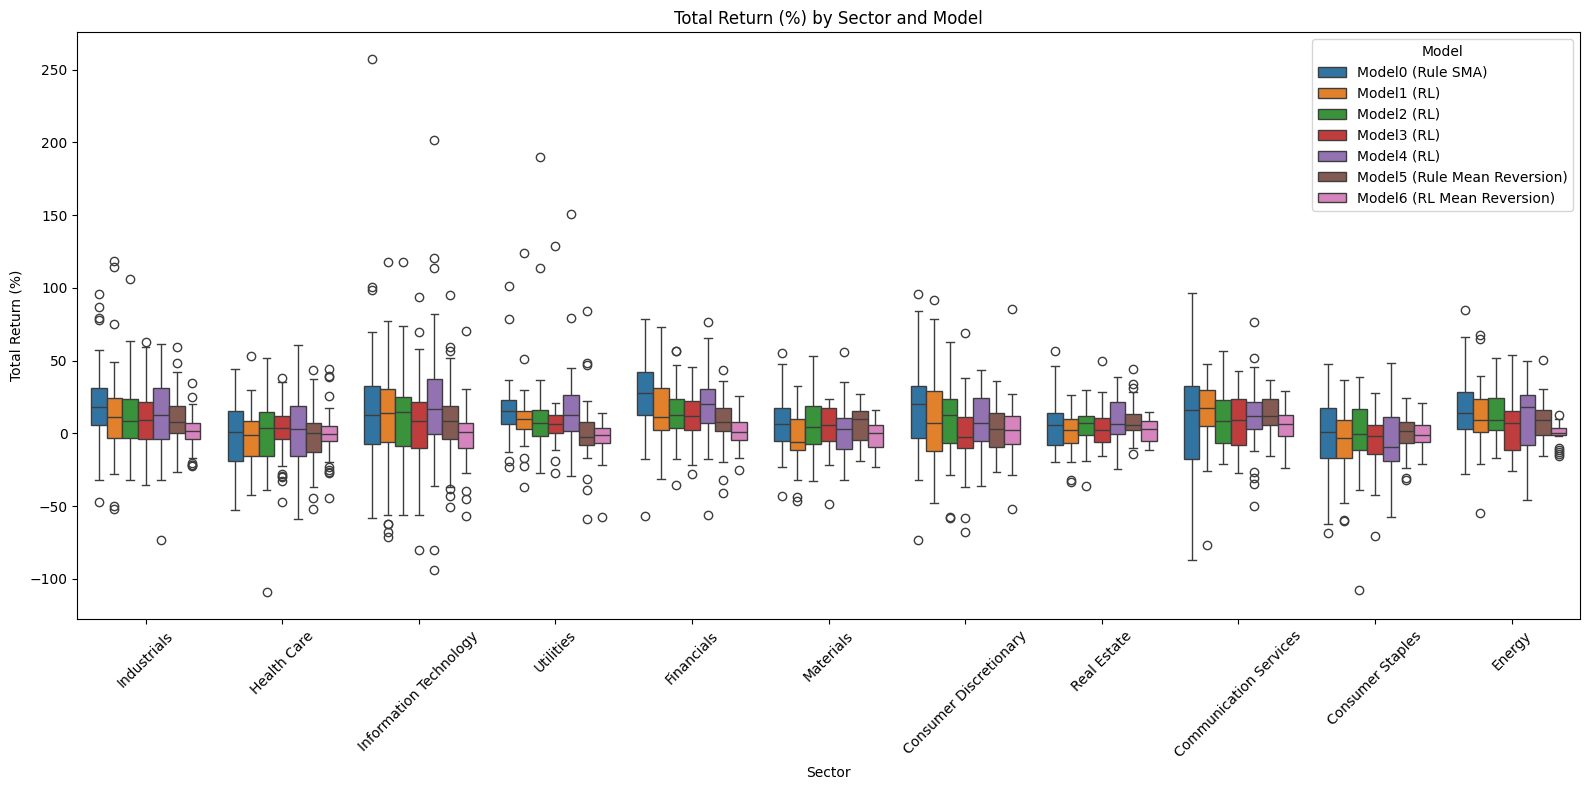

In [25]:
plt.figure(figsize=(16, 8))
sns.boxplot(x="Sector", y="Total Return (%)", hue="Model", data=df_all)
plt.xticks(rotation=45)
plt.title("Total Return (%) by Sector and Model")
plt.tight_layout()
plt.show()

#### Part III - Additional Analysis
* Slice and Analyze by Sector
* Find Top Performing Models by Sector
* Rank Sectors by Model Consistency
* Sector-by-Sector Leaderboard Table

In [26]:
# Slice and Analyze by Sector
sector_summary = df_all.groupby('Sector')["Total Return (%)"].mean().sort_values(ascending=False)
display(sector_summary)

Sector
Financials                13.857808
Industrials               10.915165
Information Technology    10.523292
Communication Services    10.236460
Utilities                  9.525115
Energy                     9.368199
Consumer Discretionary     7.049244
Real Estate                5.121060
Materials                  2.746593
Health Care               -0.174524
Consumer Staples          -2.997519
Name: Total Return (%), dtype: float64

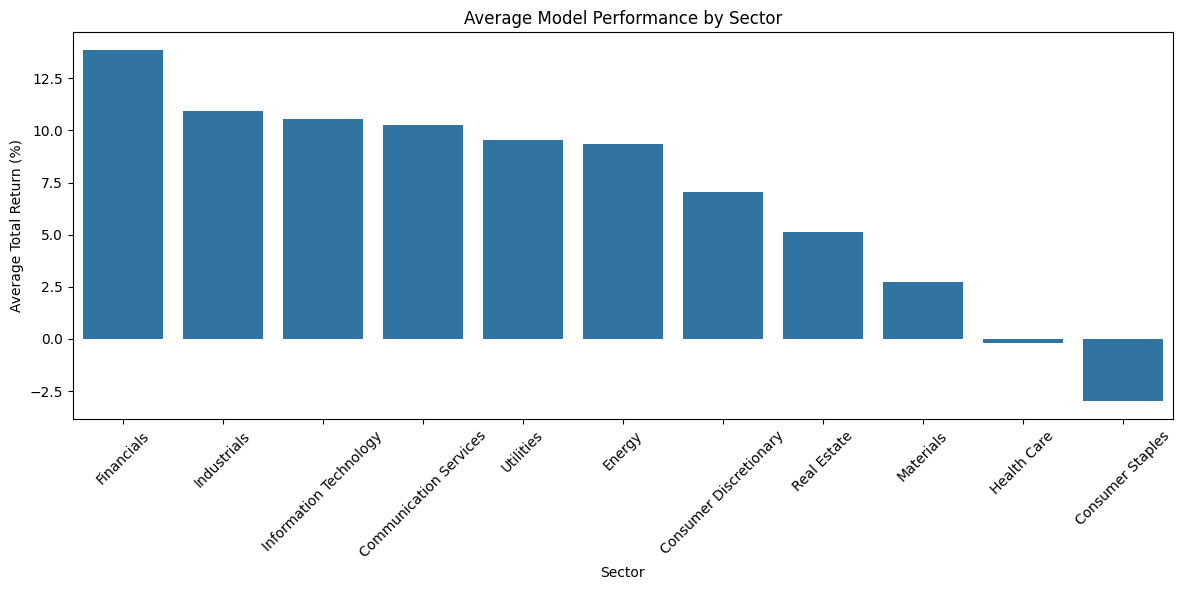

In [27]:
plt.figure(figsize=(12, 6))
sns.barplot(x=sector_summary.index, y=sector_summary.values)
plt.xticks(rotation=45)
plt.ylabel("Average Total Return (%)")
plt.title("Average Model Performance by Sector")
plt.tight_layout()
plt.show()

In [28]:
# Find Top Performing Models by Sector
df_all['Rank'] = df_all.groupby(['Ticker'])["Total Return (%)"].rank(ascending=False)

top2_models_by_sector = (
    df_all[df_all["Rank"] <= 2]
    .groupby(['Sector', 'Model'])
    .size()
    .unstack(fill_value=0)
)

top2_models_by_sector_pct = (top2_models_by_sector.T / top2_models_by_sector.sum(axis=1).sum()) * 100
display(top2_models_by_sector)

Model,Model0 (Rule SMA),Model1 (RL),Model2 (RL),Model3 (RL),Model4 (RL),Model5 (Rule Mean Reversion),Model6 (RL Mean Reversion)
Sector,,,,,,,
Communication Services,9,10,7,5,5,7,3
Consumer Discretionary,25,19,17,10,11,11,9
Consumer Staples,14,9,14,7,9,12,11
Energy,8,7,8,7,10,5,1
Financials,48,22,19,16,31,10,0
Health Care,19,15,19,20,17,15,15
Industrials,35,24,22,20,30,20,5
Information Technology,25,25,19,17,31,17,4
Materials,8,4,9,9,7,12,3


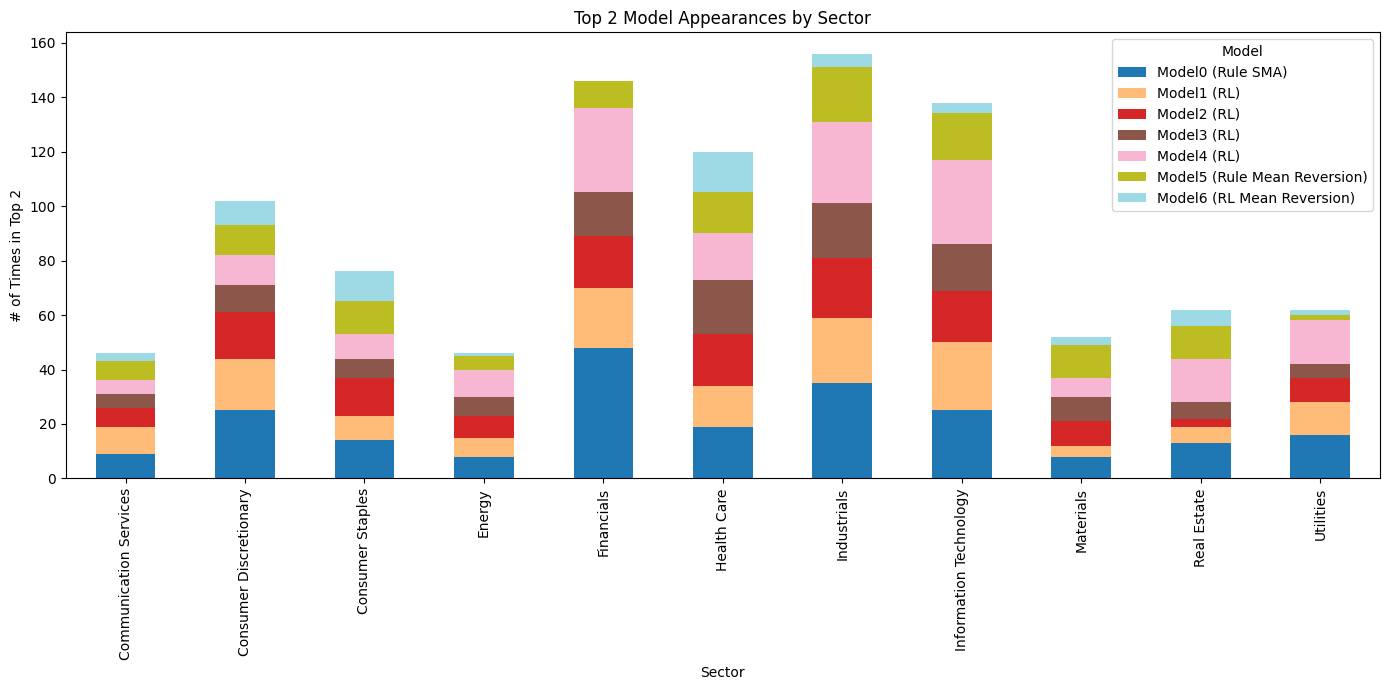

In [29]:
top2_models_by_sector.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')
plt.title("Top 2 Model Appearances by Sector")
plt.ylabel("# of Times in Top 2")
plt.tight_layout()
plt.show()

In [30]:
# Get count of appearances in Top 2 by sector and model
sector_consistency = (
    df_all[df_all['Rank'] <= 2]
    .groupby(['Sector', 'Model'])
    .size()
    .unstack(fill_value=0)
)

# Only use numeric part for computing max
numeric_only = sector_consistency.select_dtypes(include='number')

# Add Top Model columns
sector_consistency['Top Model'] = numeric_only.idxmax(axis=1)
sector_consistency['Top Model Count'] = numeric_only.max(axis=1)

# Sort by consistency
sector_consistency = sector_consistency.sort_values('Top Model Count', ascending=False)

# Display top-performing model per sector
display(sector_consistency[['Top Model', 'Top Model Count']])


Model,Top Model,Top Model Count
Sector,,
Financials,Model0 (Rule SMA),48
Industrials,Model0 (Rule SMA),35
Information Technology,Model4 (RL),31
Consumer Discretionary,Model0 (Rule SMA),25
Health Care,Model3 (RL),20
Real Estate,Model4 (RL),16
Utilities,Model0 (Rule SMA),16
Consumer Staples,Model0 (Rule SMA),14
Materials,Model5 (Rule Mean Reversion),12


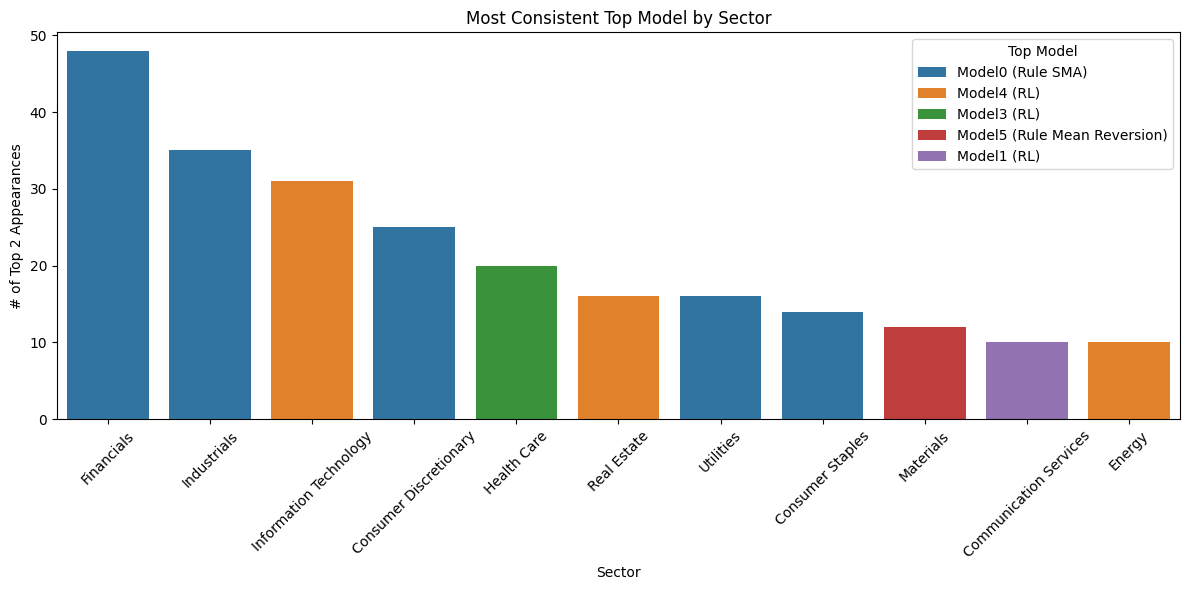

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=sector_consistency.index,
    y=sector_consistency["Top Model Count"],
    hue=sector_consistency["Top Model"],
    dodge=False
)
plt.xticks(rotation=45)
plt.title("Most Consistent Top Model by Sector")
plt.ylabel("# of Top 2 Appearances")
plt.tight_layout()
plt.show()


In [32]:
# Sector-by-Sector Leaderboard Table
leaderboard = []

for sector in df_all['Sector'].unique():
    sector_df = df_all[df_all['Sector'] == sector]
    top_model = (
        sector_df.groupby('Model')["Total Return (%)"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )
    leaderboard.append({
        'Sector': sector,
        'Best Model': top_model.iloc[0]['Model'],
        'Avg Return (%)': round(top_model.iloc[0]['Total Return (%)'], 2)
    })

leaderboard_df = pd.DataFrame(leaderboard).sort_values("Avg Return (%)", ascending=False)
display(leaderboard_df)


,Sector,Best Model,Avg Return (%)
4,Financials,Model0 (Rule SMA),26.76
2,Information Technology,Model4 (RL),20.11
0,Industrials,Model0 (Rule SMA),19.07
3,Utilities,Model4 (RL),18.34
6,Consumer Discretionary,Model0 (Rule SMA),18.00
10,Energy,Model0 (Rule SMA),17.86
8,Communication Services,Model1 (RL),12.64
7,Real Estate,Model5 (Rule Mean Reversion),9.02
5,Materials,Model0 (Rule SMA),8.13
1,Health Care,Model3 (RL),2.68


#### Export
* will be used later with streamlit app

In [33]:
df_all.to_csv("df_all.csv", index=False)
summary_table.to_csv("summary_table.csv")
sector_model_avg.to_csv("sector_model_avg.csv")
sector_consistency.to_csv("sector_consistency.csv")